In [5]:
import numpy as np
import pandas as pd

In [2]:
import os
#from google.colab import drive
#drive.mount('/content/drive')

os.listdir()
os.chdir("./drive/MyDrive/Colab Notebooks/")

In [6]:
# load and preprocess data
__DATA_DIR__ = "./data-playground/sample_data_final.csv"

df = pd.read_csv(__DATA_DIR__,header = "infer")

df = df.drop(["user_id",
              "orders_outlier_ind",
              "room_nights_outlier_ind",
              "booking_gbv_outlier_ind",
              ],axis=1).reset_index(drop = True)

#df.head()

In [7]:
from ABLib import ABAnalyser

train = df[df["experiment_variant_code"]== "CONTROL"].drop("experiment_variant_code",axis = 1)
test = df[df["experiment_variant_code"] == "VARIANT"].drop("experiment_variant_code",axis = 1)
features = ["new_return_visitor","platform_type","posa_super_region","marketing_channel"]
targets = ["orders","room_nights","booking_gbv"]

analyser = ABAnalyser(train,test)


[Levene] Test homogenity of variance: Target orders P-val = 0.007542841212449814
[Levene] Test homogenity of variance: Target room_nights P-val = 0.0029992263225453544
[Levene] Test homogenity of variance: Target booking_gbv P-val = 0.03490087079446098
['orders', 'room_nights', 'booking_gbv']


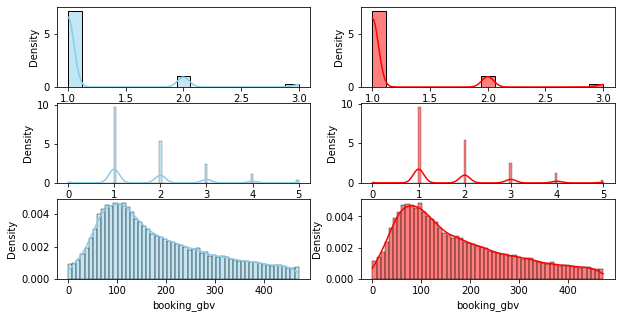

In [16]:
#analyser.checkAdversarialLabel(features,sample_frac = 0.1,verbose = True)

#print(analyser.checkCovBalance(features,verbose = False))

#ls,train,test = analyser.detectTailedOutlier(targets, remove_outlier = True, verbose = True)
analyser.setData(train[train["conv_ind"]>0],test[test["conv_ind"]>0])

#print(analyser.checkGroupNormality(train[train["conv_ind"]>0],
#                                   targets,
#                                   plot_dist = True,
#                                   verbose = True))

print(analyser.checkABHomogVariance(targets,plot_dist = True,verbose = True))

#print(analyser.computePVal(["conv_ind"],verbose = True))